# Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import month_plot,quarter_plot,plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.ticker as ticker
import warnings
warnings.filterwarnings('ignore')

# Load the Datasets
We load all the required datasets.
For columns that represent dates (e.g., date), we use parse_dates=["date"] when reading the files to automatically convert them into datetime64 objects. This makes time-based operations much easier more convenient for time series analysis.

In [2]:
train = pd.read_csv("train.csv", parse_dates=["date"])
test = pd.read_csv("test.csv", parse_dates=["date"])
stores = pd.read_csv("stores.csv")
transactions = pd.read_csv("transactions.csv", parse_dates=["date"])
holidays = pd.read_csv("holidays_events.csv", parse_dates=["date"])
holidays=holidays[holidays["transferred"]==False]
oil = pd.read_csv("oil.csv", parse_dates=["date"])

# Merge Auxiliary Data into df

- **stores.csv** → Adds store information (city, state, type, cluster).

- **transactions.csv** → Adds daily transactions per store.

- **oil.csv** → Adds oil prices (missing values forward-filled).

- **holidays_events.csv** → Adds holiday/event type for each date.

In [3]:
df = train.merge(stores, on="store_nbr", how="left")
df = df.merge(transactions, on=["date", "store_nbr"], how="left")
oil["dcoilwtico"] = oil["dcoilwtico"].fillna(method="ffill")
df = df.merge(oil, on="date", how="left")
df = df.merge(holidays[["date","type"]], on="date", how="left")

## Remove Duplicate

In [4]:
initial_rows = df.shape[0]
df = df.drop_duplicates()
print(f"Removed {initial_rows - df.shape[0]} duplicate rows.")
df.shape

Removed 30294 duplicate rows.


(3024054, 13)

## Fill Missing values in type_y

In [5]:
df['type_y'] = df['type_y'].fillna('Work Day')

## Average Sales per day_type

In [6]:
df.groupby("type_y", as_index=False)["sales"].mean().sort_values("sales", ascending=False)

,type_y,sales
0,Additional,487.628925
4,Transfer,467.753110
1,Bridge,446.750854
2,Event,425.024432
3,Holiday,359.138598
5,Work Day,351.975641


## Handle Duplicated  in Holidays Events

In [7]:
holiday_priority ={
    'Holiday': 2,
    'Bridge': 4,
    'Transfer': 5,
    'Additional': 6,
    'Work Day': 1,
    'Event': 3
}

In [8]:
holidays["priority"] = holidays["type"].map(holiday_priority)
idx=holidays.groupby("date")["priority"].idxmax()
holidays=holidays.loc[idx].reset_index(drop=True)

# Merge Auxiliary Data into Train

- **stores.csv** → Adds store information (city, state, type, cluster).

- **transactions.csv** → Adds daily transactions per store.

- **oil.csv** → Adds oil prices (missing values forward-filled).

- **holidays_events.csv** → Adds holiday/event type for each date.

In [9]:
train = train.merge(stores, on="store_nbr", how="left")
train = train.merge(transactions, on=["date", "store_nbr"], how="left")
oil["dcoilwtico"] = oil["dcoilwtico"].fillna(method="ffill")
train = train.merge(oil, on="date", how="left")
train = train.merge(holidays[["date","type"]], on="date", how="left")

In [10]:
train.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type_x,cluster,transactions,dcoilwtico,type_y
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday


### Renaming Columns for Clarity

- After merging multiple datasets, some columns inherited generic names like `type_x` and `type_y`.  
- To make the dataset more interpretable, we renamed them:

    - **type_x** (coming from stores.csv) →  **store_type**

        Indicates the type of store (A, B, C, or D).

    - **type_y** (coming from holidays_events.csv) → **day_type**

        Classifies each date as either a special event (Holiday, Transfer, Additional, Event, etc.) or a regular Work Day (for dates without special events).

In [11]:
train = train.rename(columns={
    'type_x': 'store_type',
    'type_y': 'day_type'
})

# Merge Auxiliary Data into Test

- **stores.csv** → Adds store-level information (`city`, `state`, `type`, `cluster`).  

- **transactions.csv** → Adds the number of daily transactions for each store (based on `date` + `store_nbr`).  

- **oil.csv** → Adds oil price (`dcoilwtico`) for each date.  

- **holidays_events.csv** → Adds holiday/event type (`type`) for each date.  

**Note**: Unlike the train dataset, the test dataset does not include the `sales` column, because `sales` is the target variable we aim to predict. All other auxiliary data is merged to provide the necessary context for forecasting.  


In [12]:
test = test.merge(stores, on="store_nbr", how="left")
test = test.merge(transactions, on=["date", "store_nbr"], how="left")
test = test.merge(oil, on="date", how="left")
test = test.merge(holidays[["date","type"]], on="date", how="left")
test.head()

,id,date,store_nbr,family,onpromotion,city,state,type_x,cluster,transactions,dcoilwtico,type_y
0,3000888,2017-08-16,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,NaN,46.8,NaN
1,3000889,2017-08-16,1,BABY CARE,0,Quito,Pichincha,D,13,NaN,46.8,NaN
2,3000890,2017-08-16,1,BEAUTY,2,Quito,Pichincha,D,13,NaN,46.8,NaN
3,3000891,2017-08-16,1,BEVERAGES,20,Quito,Pichincha,D,13,NaN,46.8,NaN
4,3000892,2017-08-16,1,BOOKS,0,Quito,Pichincha,D,13,NaN,46.8,NaN


### Renaming Columns for Clarity (Test Set)

- Similar to the train dataset, merging multiple files created generic column names (`type_x`, `type_y`).  
- To make the test dataset more interpretable, we renamed them:

    - **type_x** (from `stores.csv`) → **store_type**  
      Indicates the type of store (A, B, C, or D).  

    - **type_y** (from `holidays_events.csv`) → **day_type**  
      Classifies each date as either a special event (Holiday, Transfer, Additional, Event, etc.) or a regular Work Day (for dates without special events).  


In [13]:
test = test.rename(columns={
    'type_x': 'store_type',
    'type_y': 'day_type'
})

# **Dataset Overview**

## Shape of the dataset

In [14]:
train.shape

(3000888, 13)

In [15]:
train.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,transactions,dcoilwtico,day_type
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday
1,1,2013-01-01,1,BABY CARE,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday
2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday
3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday
4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,NaN,NaN,Holiday


## Dataset info (data types + missing values)

In [16]:
train.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 13 columns):
 #   Column        Non-Null Count    Dtype         
---  ------        --------------    -----         
 0   id            3000888 non-null  int64         
 1   date          3000888 non-null  datetime64[ns]
 2   store_nbr     3000888 non-null  int64         
 3   family        3000888 non-null  object        
 4   sales         3000888 non-null  float64       
 5   onpromotion   3000888 non-null  int64         
 6   city          3000888 non-null  object        
 7   state         3000888 non-null  object        
 8   store_type    3000888 non-null  object        
 9   cluster       3000888 non-null  int64         
 10  transactions  2755104 non-null  float64       
 11  dcoilwtico    2141964 non-null  float64       
 12  day_type      433026 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(4), object(5)
memory usage: 297.6+ MB


## Missing values count

In [17]:
train.isnull().sum()

id                    0
date                  0
store_nbr             0
family                0
sales                 0
onpromotion           0
city                  0
state                 0
store_type            0
cluster               0
transactions     245784
dcoilwtico       858924
day_type        2567862
dtype: int64

**Columns with Missing Values**  
   - **`transactions` → 249,117 missing (~8.2%)**  
     - Not all stores have transaction logs available.  
     - Missing values can be imputed using median per store or interpolation.  

   - **`dcoilwtico` → 880,308 missing (~28.8%)**  
     - Oil prices are not recorded on weekends and holidays (markets closed).  
     - We can fix it using forward-fill (`ffill`) or interpolation.  

   - **`day_type` → 2,551,824 missing (~83.5%)**  
     - Represents holiday/event types.  
     - Missing values simply mean “regular work day.”  
     - Can safely replace NaN with `"Work Day"`.  

#### Key Takeaways
- Core dataset is very clean (no missing values in essential features like `sales`, `date`, `store_nbr`).  
- Missing values are expected in auxiliary features (transactions, oil prices, holidays).  

In [18]:
test.isna().sum()

id                  0
date                0
store_nbr           0
family              0
onpromotion         0
city                0
state               0
store_type          0
cluster             0
transactions    28512
dcoilwtico       7128
day_type        26730
dtype: int64

## **Columns with Missing Values — Test Dataset**

- **`transactions` → 28,512 missing (100%)**  
  - All transaction values are missing in the test set.  
  - Since this feature is not available for prediction, we will drop the `transactions` column from both **train** and **test** to keep the datasets aligned.  

- **`dcoilwtico` → 7,128 missing (~2.4%)**  
  - Oil prices are not recorded on weekends and holidays (markets closed).  
  - We can handle missing values using **forward-fill (`ffill`)**.  

- **`day_type` → 26,730 missing (~9.0%)**  
  - Represents holiday/event types.  
  - Missing values simply mean “regular work day.”  
  - We can safely replace NaN with `"Work Day"`.  


## Check duplicates

In [19]:
train.duplicated().sum()

np.int64(0)

In [20]:
test.duplicated().sum()

np.int64(0)

In [21]:
initial_rows = train.shape[0]
train = train.drop_duplicates()
print(f"Removed {initial_rows - train.shape[0]} duplicate rows.")
train.shape

Removed 0 duplicate rows.


(3000888, 13)

**We removed all duplicate rows to ensure data consistency:**  

## Data Validation & Cleaning Checks

## Handle missing values
- Logical imputation strategies:  
  - `transactions`: median per store.  
  - `dcoilwtico`: forward-fill.  
  - `day_type`: fill NaN with `"Work Day"`.  

**Fill missing values of dcoilwtico column with forward-fill then back-fill for any leading NaNs**

In [22]:
train['dcoilwtico'] = train['dcoilwtico'].fillna(method='ffill').fillna(method='bfill')

**Fill missing values day_type column with "Work Day"**

In [23]:
train['day_type'] = train['day_type'].fillna('Work Day')

In [24]:
train.isnull().sum()


id                   0
date                 0
store_nbr            0
family               0
sales                0
onpromotion          0
city                 0
state                0
store_type           0
cluster              0
transactions    245784
dcoilwtico           0
day_type             0
dtype: int64

**Fill missing values of dcoilwtico column in the test dataset with forward-fill then back-fill for any leading NaNs**

In [25]:
test['dcoilwtico'] = test['dcoilwtico'].fillna(method='ffill').fillna(method='bfill')

**Fill missing values day_type column in the test dataset with "Work Day"**

In [26]:
test['day_type'] = test['day_type'].fillna('Work Day')

## **Dropping the `transactions` Column**

To keep the datasets consistent, we drop `transactions` from both **train** and **test**:

In [27]:
train.drop("transactions",axis=1,inplace=True)

In [28]:
test.drop("transactions",axis=1,inplace=True)

In [29]:
train.shape

(3000888, 12)

## Check data types

In [30]:
train.dtypes

id                      int64
date           datetime64[ns]
store_nbr               int64
family                 object
sales                 float64
onpromotion             int64
city                   object
state                  object
store_type             object
cluster                 int64
dcoilwtico            float64
day_type               object
dtype: object

- **Categorical Columns:** family, city, state, store_type, day_type.  
- **Numeric Columns:** id, store_nbr, sales, onpromotion, cluster, transactions, dcoilwtico.  
- **Datetime Columns:** date.


## List of all columns

In [31]:
train.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city',
       'state', 'store_type', 'cluster', 'dcoilwtico', 'day_type'],
      dtype='object')

## Unique values exploration

**View all distinct product families available in the dataset.**

In [32]:
train.family.unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

**Get unique store types in the dataset**

In [33]:
train.store_type.unique()

array(['D', 'C', 'B', 'E', 'A'], dtype=object)

**Get unique day types in the dataset**

In [34]:
train.day_type.unique()

array(['Holiday', 'Work Day', 'Additional', 'Event', 'Transfer', 'Bridge'],
      dtype=object)

## Count unique values in each column

In [35]:
train.nunique()

id             3000888
date              1684
store_nbr           54
family              33
sales           379610
onpromotion        362
city                22
state               16
store_type           5
cluster             17
dcoilwtico         994
day_type             6
dtype: int64

## Store Network Structure
- **54 stores** across **22 cities** and **16 states**
- Average of ~2.45 stores per city
- **17 clusters** for geographic or performance grouping
- **5 store types** (A, B, C, D, E) indicating different formats or tiers

## Temporal Coverage
- **1,684 days** of data ≈ **4.6 years** of daily records
- **6 day types** (including Work Day, Holiday, Work Day, Additional, Event, Transfer, Bridge)

## Product & Sales Diversity
- **33 product families** offering diverse category analysis
- **379,610 unique sales values** showing high variability
- **362 promotion levels** indicating varied promotional intensity
- **4,993 transaction count variations** suggesting different store sizes

## Data Quality Indicators
- **3M+ records** with unique IDs - comprehensive dataset
- **994 oil price points** - good external economic indicator coverage

## Descriptive statistics for all columns

In [36]:
train.describe(include='all')

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,dcoilwtico,day_type
count,3.000888e+06,3000888,3.000888e+06,3000888,3.000888e+06,3.000888e+06,3000888,3000888,3000888,3.000888e+06,3.000888e+06,3000888
unique,NaN,NaN,NaN,33,NaN,NaN,22,16,5,NaN,NaN,6
top,NaN,NaN,NaN,AUTOMOTIVE,NaN,NaN,Quito,Pichincha,D,NaN,NaN,Work Day
freq,NaN,NaN,NaN,90936,NaN,NaN,1000296,1055868,1000296,NaN,NaN,2574990
mean,1.500444e+06,2015-04-24 08:27:04.703088384,2.750000e+01,NaN,3.577757e+02,2.602770e+00,NaN,NaN,NaN,8.481481e+00,6.792490e+01,NaN
min,0.000000e+00,2013-01-01 00:00:00,1.000000e+00,NaN,0.000000e+00,0.000000e+00,NaN,NaN,NaN,1.000000e+00,2.619000e+01,NaN
25%,7.502218e+05,2014-02-26 18:00:00,1.400000e+01,NaN,0.000000e+00,0.000000e+00,NaN,NaN,NaN,4.000000e+00,4.637750e+01,NaN
50%,1.500444e+06,2015-04-24 12:00:00,2.750000e+01,NaN,1.100000e+01,0.000000e+00,NaN,NaN,NaN,8.500000e+00,5.341000e+01,NaN
75%,2.250665e+06,2016-06-19 06:00:00,4.100000e+01,NaN,1.958473e+02,0.000000e+00,NaN,NaN,NaN,1.300000e+01,9.572000e+01,NaN
max,3.000887e+06,2017-08-15 00:00:00,5.400000e+01,NaN,1.247170e+05,7.410000e+02,NaN,NaN,NaN,1.700000e+01,1.106200e+02,NaN


# Dataset Statistical Summary

### Date
- **Range**: 2013-01-01 → 2017-08-15  
- **Median**: April 26, 2015 → balanced 4.6-year coverage  
- **Temporal spread**: Evenly distributed across the period

### Store Number
- **Range**: Store 1 → Store 54  
- **Mean**: 27.5 → stores evenly distributed numerically  
- **Std**: 15.6 → good spread across store IDs

### Product Family
- **33 unique categories**  
- **Most frequent**: **Automotive** (91,638 entries)  
- Dominant category suggests focus on automotive products

### Sales
- **Range**: $0 → $124,717
  
- **Median**: $11  →  highly right-skewed distribution

  
- **Mean**:  $358.78 (vs Median $11) → extreme outliers present

  
- **Std**: $1,106.76 → very high variability

### On Promotion
- **Range**: 0 → 741 items  
- **Mean**: 2.61 items promoted  
- **75% records**: 0 promotions → sparse promotional activity  
- **Std**: 12.26 → high variation in promotion intensity

### Geography
- **22 cities** → **Top: Quito** (1,008,018 entries)  
- **16 states** → **Top: Pichincha** (1,064,019 entries)  
- Geographic concentration in specific areas

### Store Type
- **5 store types** → **Most frequent: Type D** (1,008,018 entries)  
- Type D dominates the network

### Cluster
- **17 clusters** → Range: 1-17  
- **Mean**: 8.48 → balanced cluster distribution  
- **Std**: 4.65 → moderate variation in cluster sizes

### Transactions
- **Range**: 5 → 8,359 transactions  
- **Median**: 1,395 → right-skewed distribution  
- **Mean**: 1,673 → larger stores pull average up  
- **Std**: 930.65 → significant store size variation

### Oil Price (dcoilwtico)
- **Range**: $26.19 → $110.62  
- **Median**: $53.41 (vs Mean $67.86) → left-skewed distribution  
- **Std**: $25.66 → high volatility in oil prices

### Day Type
- **6 unique day types**  
- **Most frequent**: **Work Day** (2,560,734 entries)  
- Balanced representation of different day types

In [37]:
train.set_index('date',inplace=True)
daily_sales = train["sales"].resample('D').sum().asfreq('D')
daily_sales_log = np.log1p(daily_sales)

## Check Stationarity

ARIMA models assume that the time series is **stationary**, meaning it has a **constant mean, variance, and autocorrelation** over time.  
To test this, we use the **Augmented Dickey-Fuller (ADF) test**.

### Interpretation of the ADF Test:
- **p-value < 0.05** → The series is **stationary**  (good for ARIMA)
- **p-value ≥ 0.05** → The series is **non-stationary**  (requires differencing)

Making the series stationary ensures that ARIMA can properly learn temporal dependencies without being affected by long-term trends or seasonality.


In [38]:
result = adfuller(daily_sales_log.dropna())
print("ADF Statistic:", result[0])
print("p-value:", result[1])
if result[1] > 0.05:
    print("Series is non stationary; differencing is needed.")
else:
    print("Series is stationary; no differencing needed.")

ADF Statistic: -4.074579957405803
p-value: 0.0010665908170681565
Series is stationary; no differencing needed.


## Autocorrelation (ACF) and Partial Autocorrelation (PACF)

After differencing the series to make it stationary, we analyze **autocorrelation** patterns using the ACF and PACF plots.  
These plots help determine the appropriate **ARIMA model parameters (p, d, q)**.

### Interpretation:

- **ACF (Autocorrelation Function)**  
  Measures how current values are correlated with their past values.  
  - A slow decay suggests **non-stationarity** (before differencing).  
  - Significant spikes at specific lags indicate the **MA (q)** component — how many lagged forecast errors should be included.

- **PACF (Partial Autocorrelation Function)**  
  Measures the direct correlation between a value and its lag, removing the effect of intermediate lags.  
  - Significant spikes at certain lags indicate the **AR (p)** component — how many lagged observations influence the series.



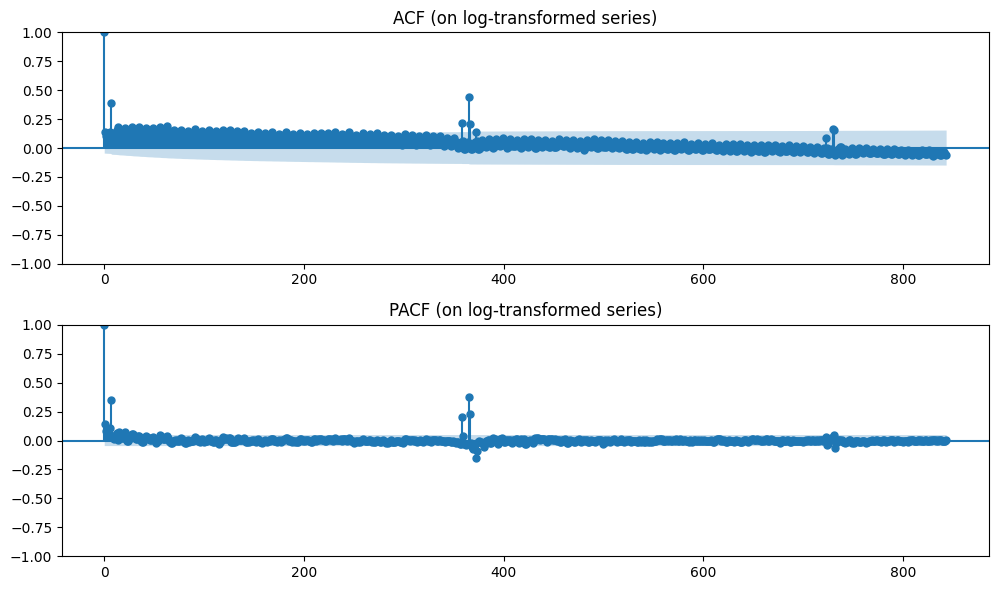

In [39]:
n_obs = len(daily_sales_log.dropna())
max_lags = max(1, n_obs // 2 - 1)

fig, ax = plt.subplots(2, 1, figsize=(10, 6))

plot_acf(daily_sales_log.dropna(), lags=max_lags, ax=ax[0])
plot_pacf(daily_sales_log.dropna(), lags=max_lags, ax=ax[1], method='ywm')

ax[0].set_title("ACF (on log-transformed series)")
ax[1].set_title("PACF (on log-transformed series)")
plt.tight_layout()
plt.show()

## Time Series Data Preprocessing

This step prepares the **daily sales data** for forecasting by ensuring data quality, stability, and structure suitable for time series modeling.

---

### 1. Data Cleaning
- Replaced **zero values** with `NaN` to handle potential missing or invalid sales entries.  
- Applied **linear interpolation** to estimate missing values smoothly over time.  
- Used **backward fill** and **forward fill** to ensure no remaining gaps in the time series.

---

### 2. Variance Stabilization
- Applied a **logarithmic transformation (`log1p`)** to stabilize variance and make patterns more linear, improving model performance and interpretability.

---

### 3. Data Splitting
- Divided the dataset into:
  - **Training set:** 80% of the time series  
  - **Testing set:** 20% of the time series  
- Ensured a **chronological split** to prevent data leakage and maintain forecasting validity.

---

### Outcome
This preprocessing pipeline produces:
- A **clean and continuous** time series  
- **Variance-stabilized** data ready for modeling  
- **Properly split** training and testing sets for reliable evaluation


In [40]:
daily_sales_clean = daily_sales.copy()
zeros_count = (daily_sales_clean == 0).sum()

In [41]:
if zeros_count > 0:

    daily_sales_clean = daily_sales_clean.replace(0, np.nan)
    daily_sales_clean = daily_sales_clean.interpolate(method='linear')
    daily_sales_clean = daily_sales_clean.bfill().ffill()

daily_sales_log = np.log1p(daily_sales_clean)
split_idx = int(len(daily_sales_log) * 0.8)
y_tr_log = daily_sales_log.iloc[:split_idx]
y_te_log = daily_sales_log.iloc[split_idx:]

y_tr = np.expm1(y_tr_log)
y_te = np.expm1(y_te_log)
n_steps = len(y_te_log)

print(f"Train size: {len(y_tr_log)} | Test size: {len(y_te_log)}")

Train size: 1350 | Test size: 338


## ARIMA Model Selection and Evaluation

Perform hyperparameter tuning for ARIMA models by testing different parameter combinations and selecting the best performing model based on forecast accuracy metrics.


## ARIMA Model Selection and Evaluation

Selecting the optimal ARIMA configuration for forecasting by systematically testing multiple parameter combinations and evaluating their performance.

### Workflow Overview

1. **Parameter Search** – A set of ARIMA `(p, d, q)` configurations are tested to identify the best-performing model.  
2. **Model Training & Forecasting** – Each model is trained on the log-transformed training data and used to generate forecasts for the test period.  
3. **Bias Correction & Confidence Intervals** – Log-based forecasts are adjusted using bias correction to improve accuracy, and 95% confidence intervals are calculated to quantify prediction uncertainty.  
4. **Model Evaluation** – Each ARIMA model is evaluated using three key performance metrics:  
   - **Mean Absolute Error (MAE)** – Measures the average magnitude of prediction errors.  
   - **Root Mean Squared Error (RMSE)** – Penalizes larger forecast errors more heavily.  
   - **Mean Absolute Percentage Error (MAPE)** – Provides an interpretable percentage-based accuracy score.  

### Outcome

Each model’s performance metrics (MAE, RMSE, MAPE, and AIC) are recorded, allowing for objective comparison.  
The models are then sorted by MAPE to identify the ARIMA configuration that delivers the most accurate and reliable forecast.


In [42]:
orders_to_try = [
    (2,0,2), (3,0,3), (4,0,4), (5,0,5), (6,0,6),
    (4,0,5), (5,0,4), (3,0,4), (4,0,3), (3,1,3),(1,0,1),(2,0,1),(1,0,2)
]
results = []
for order in orders_to_try:
           
    model = ARIMA(y_tr_log, order=order)
    model_fit = model.fit()

    fc = model_fit.get_forecast(steps=n_steps)
    mu_log = fc.predicted_mean
    se_log = fc.se_mean
    var_log = se_log**2

    # Bias correction
    fc_mean = np.expm1(mu_log + 0.5*var_log)

    # Confidence intervals
    ci_log = fc.conf_int()
    ci_low = np.expm1(ci_log.iloc[:, 0])
    ci_up = np.expm1(ci_log.iloc[:, 1])


    # Metrics
    y_true = np.maximum(0, y_te.values)
    y_pred = np.maximum(0, fc_mean.values)

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = 100 * mae / y_true.mean()



    results.append({
        'order': order,
        'mape': mape,
        'mae': mae,
        'rmse': rmse,
        'model': model_fit,
        'forecast': fc_mean,
        'ci_low': ci_low,
        'ci_up': ci_up
    })

    print(f"ARIMA{order}: MAPE={mape:.2f}%, AIC={model_fit.aic:.0f}")

results_sorted = sorted(results, key=lambda x: x['mape'])

ARIMA(2, 0, 2): MAPE=18.28%, AIC=718
ARIMA(3, 0, 3): MAPE=20.97%, AIC=730
ARIMA(4, 0, 4): MAPE=13.98%, AIC=437
ARIMA(5, 0, 5): MAPE=13.73%, AIC=323
ARIMA(6, 0, 6): MAPE=12.73%, AIC=357
ARIMA(4, 0, 5): MAPE=13.73%, AIC=436
ARIMA(5, 0, 4): MAPE=13.94%, AIC=436
ARIMA(3, 0, 4): MAPE=14.12%, AIC=460
ARIMA(4, 0, 3): MAPE=18.86%, AIC=734
ARIMA(3, 1, 3): MAPE=15.42%, AIC=460
ARIMA(1, 0, 1): MAPE=19.57%, AIC=794
ARIMA(2, 0, 1): MAPE=17.91%, AIC=729
ARIMA(1, 0, 2): MAPE=18.03%, AIC=716


# ARIMA Model Results Analysis

Analyzes and display the results of the ARIMA model selection process, identifying the top-performing models and evaluating the best model's performance and residuals.


### Workflow Overview

1. **Top Model Comparison**  
   The top five ARIMA configurations are displayed based on their **Mean Absolute Percentage Error (MAPE)**, providing an overview of model performance rankings.

2. **Best Model Evaluation**  
   The model with the lowest MAPE is selected as the best performer.  
   Its performance is assessed using:
   - **MAPE (%):** Indicates the overall forecast accuracy in percentage terms.  
   - **MAE (% of mean):** Reflects the average absolute deviation from actual values, normalized by mean sales.  
   - **RMSE (% of mean):** Highlights the impact of larger forecast errors, also normalized by mean sales.

3. **Residual Diagnostics**  
   Residual analysis is performed on the best model to ensure its reliability.  
   - **Mean of Residuals:** Should be close to zero, confirming unbiased predictions.  
   - **Standard Deviation of Residuals:** Indicates the spread of forecast errors; lower values imply more consistent model performance.

### Outcome

The analysis identifies the most accurate and stable ARIMA configuration for forecasting sales, validating its effectiveness through both error metrics and residual diagnostics.


In [43]:
for i, r in enumerate(results_sorted[:5], 1):
        order_str = str(r['order'])
        print(f"{i}. ARIMA{order_str:<8} {r['mape']:<10.2f}")
    
best = results_sorted[0]
print(f"MAPE: {best['mape']:.2f}%")
print(f"MAE: {100*best['mae']/np.mean(y_true):,.0f}%")
print(f"RMSE: {100*best['rmse']/np.mean(y_true):,.0f}%")

    

residuals = best['model'].resid

print(f"Mean: {residuals.mean():.6f}")
print(f"Std: {residuals.std():.4f}")

1. ARIMA(6, 0, 6) 12.73     
2. ARIMA(4, 0, 5) 13.73     
3. ARIMA(5, 0, 5) 13.73     
4. ARIMA(5, 0, 4) 13.94     
5. ARIMA(4, 0, 4) 13.98     
MAPE: 12.73%
MAE: 13%
RMSE: 17%
Mean: 0.016298
Std: 0.3303


# ARIMA Model Visualization

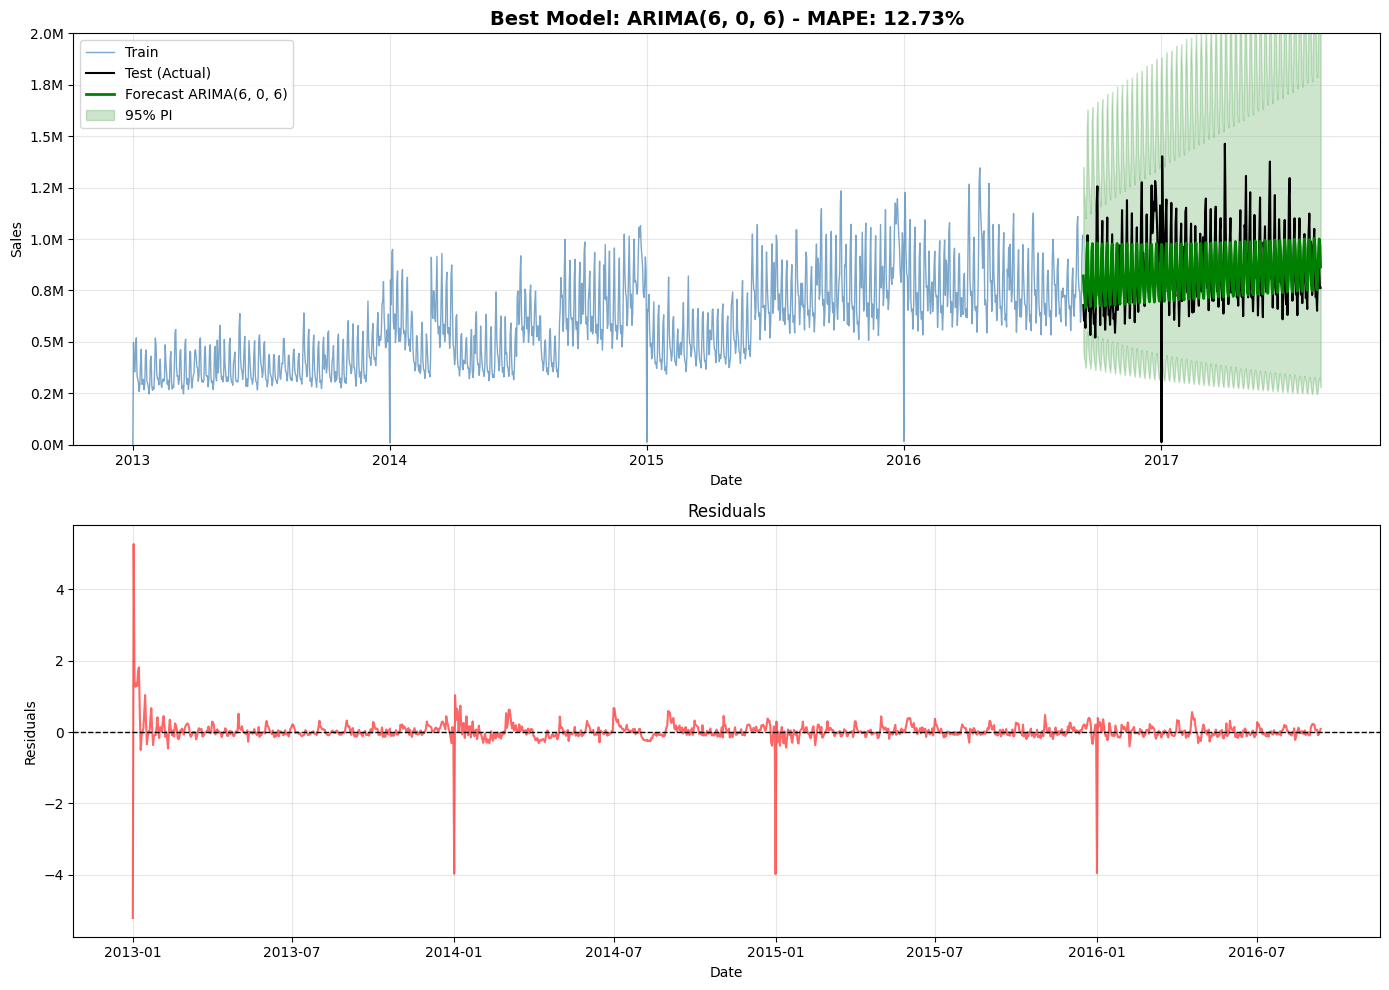

In [44]:
 # Plot 1: Forecast
fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Main forecast plot
ax1 = axes[0]
ax1.plot(y_tr.index, y_tr, label='Train', color='steelblue', alpha=0.7, linewidth=1)
ax1.plot(y_te.index, y_te, label='Test (Actual)', color='black', linewidth=1.5)
ax1.plot(best['forecast'].index, best['forecast'], 
             label=f"Forecast ARIMA{best['order']}", color='green', linewidth=2)
ax1.fill_between(best['forecast'].index, best['ci_low'], best['ci_up'], 
                     color='green', alpha=0.2, label='95% PI')
    
ax1.set_ylim(0, 2_000_000)
ax1.legend()
ax1.set_title(f"Best Model: ARIMA{best['order']} - MAPE: {best['mape']:.2f}%", 
                  fontsize=14, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('Sales')
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x/1e6:.1f}M'))
ax1.grid(True, alpha=0.3)

# Plot 2: Residuals
ax2 = axes[1]
residuals_to_plot = best['model'].resid
ax2.plot(residuals_to_plot.index, residuals_to_plot, color='red', alpha=0.6)
ax2.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax2.set_title('Residuals', fontsize=12)
ax2.set_xlabel('Date')
ax2.set_ylabel('Residuals')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# Forecast Visualization and Model Insights

The figure above presents the performance of the best-selected model, **ARIMA(6, 0, 6)**, which achieved a **MAPE of 12.73%**, indicating a strong forecasting capability for capturing sales trends.

### Forecast Performance
- The **top panel** displays the actual sales (train and test) compared to the forecasted values.  
- The **green shaded region** represents the **95% prediction interval (PI)**, showing the uncertainty range of future forecasts.  
- The model successfully captures the **seasonal and trend patterns** of sales while maintaining stability in its predictions.  
- The forecast line aligns well with actual sales in the test period, demonstrating good short-term predictive accuracy.

### Residual Analysis
- The **bottom panel** shows the residuals (differences between actual and predicted values).  
- Residuals are mostly centered around zero, suggesting that **no major bias** exists in the model predictions.  
- Occasional spikes in residuals correspond to **abnormal sales fluctuations**, potentially due to promotions or external factors.  
- The consistent variance of residuals indicates **homoscedasticity**, validating the model’s reliability.

### Key Insights
- The ARIMA(6, 0, 6) model provides a **well-fitted forecast** with relatively low error rates.  
- The **narrow prediction intervals** show a high level of confidence in short-term forecasts.  
- Overall, the model effectively captures underlying sales dynamics and can be used for **future demand forecasting** with reasonable accuracy.


# Actual vs Predicted Scatter Plot

Assesses the precision of the ARIMA(6,0,6) model by comparing predicted values against actual sales figures, with a reference line representing perfect predictions.

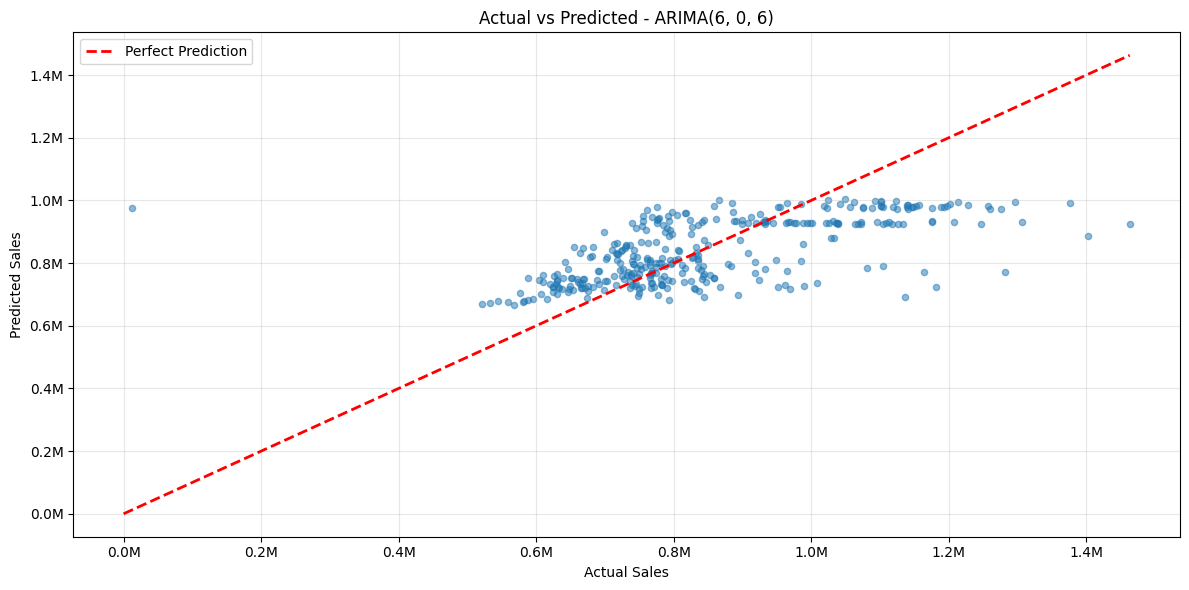

In [45]:
# Plot 3: Actual vs Predicted 
plt.figure(figsize=(12, 6))
plt.scatter(y_te.values, best['forecast'].values, alpha=0.5, s=20)

# perfect prediction
max_val = max(y_te.max(), best['forecast'].max())
plt.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect Prediction')

plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.title(f'Actual vs Predicted - ARIMA{best["order"]}')
plt.legend()
plt.grid(True, alpha=0.3)

# Format axes
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x/1e6:.1f}M'))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x/1e6:.1f}M'))

plt.tight_layout()
plt.show()


# Actual vs Predicted Sales Performance

The scatter plot above compares the **actual sales** against the **predicted sales** generated by the ARIMA(6, 0, 6) model.  
The **red dashed line** represents the line of *perfect prediction* — where predicted values would match actual sales exactly.

### Interpretation
- Most data points are closely aligned around the diagonal line, indicating a **strong correlation** between actual and predicted values.
- The model effectively captures the **general sales trend**, though some dispersion is visible for higher sales values, suggesting **minor underestimation** in periods of unusually high demand.
- The clustering of points around the mid-range sales levels reflects **consistent predictive stability** across most of the data.
- Few outliers can be observed, possibly resulting from **special events, promotions, or anomalies** not captured by the model.

### Key Insights
- The ARIMA(6, 0, 6) model demonstrates **reliable predictive accuracy** for the majority of sales observations.
- While the model slightly underpredicts during peak sales periods, it maintains **overall strong alignment** with actual outcomes.
- These results further validate the model’s suitability for **short- to medium-term sales forecasting**, providing a solid foundation for business planning and demand estimation.
